In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation


%matplotlib inline

C:\Users\prith\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# 1. Loading data and filtering Defaulted loans

In [14]:
appended_data = []
#change here to switch between before crisis and after crisis
years = list(map(str, range(2004, 2007)))
quarters = [ 'Q1', 'Q2', 'Q3', 'Q4']
for year in years: 
    for quarter in quarters:
        data2 = pd.read_csv("preprocessed_data/"+ year + quarter +"_stat.csv")
        print(year + quarter, data2.shape)
        appended_data.append(data2)
        
df = pd.concat(appended_data)
    
# Some basic formating  
df.reset_index(inplace = True)
df.drop('index', axis=1, inplace=True)

2004Q1 (452471, 70)
2004Q2 (614487, 70)
2004Q3 (389487, 70)
2004Q4 (361659, 70)
2005Q1 (303611, 70)
2005Q2 (339372, 70)
2005Q3 (440521, 70)
2005Q4 (378311, 70)
2006Q1 (253043, 70)
2006Q2 (291165, 70)
2006Q3 (271373, 70)
2006Q4 (280979, 70)


In [58]:
# collecting all the defaulted loans
data = df[df['COMPLT_FLG'].notnull()].copy(deep=True)

# Removing all columns which contain more than 90% null values
null_count = data.isnull().sum()
null_columns = null_count[null_count > data.shape[0]*(0.9)]
print(null_columns)

prop_ins_ind    223967
DEAL_NAME       223967
mod_ind         219568
MODFG_COST      219171
dtype: int64


In [59]:
# format the zb_date column
data["zb_date"] = data["zb_date"].astype("Int64").astype(str)
data["zb_date"] = data['zb_date'].str[:4] + '-' + data['zb_date'].str[4:6] + '-' + '01'

In [62]:
data["zb_date"] = pd.to_datetime(data["zb_date"], errors='coerce')
data["zb_date"] = data["zb_date"].dt.to_period("M").dt.to_timestamp("M")

# 2. Integrate the macroeconomic & state wise variables

In [65]:
McData = pd.read_csv("./Macro-Economic_Data/aggergate_macroeconomic.csv")
McData = McData.rename(columns = {'Unnamed: 0': 'Date'} )
McData["Date"] = pd.to_datetime(McData["Date"], errors='coerce')

data = data.merge(
    McData,
    how='left',
    left_on=['state', 'zb_date'],
    right_on=['state', 'Date'],
    validate='many_to_one',      # optional sanity check
    suffixes=('', '_r')          # optional suffix for overlaps
)


In [70]:
from Macro_Economic_Data.state_foreclosure import method_of_foreclosure_and_time

method_of_foreclosure_and_time = pd.DataFrame(method_of_foreclosure_and_time, columns=['state', 'method_of_foreclosurer', 'time_to_foreclose'])

data = data.merge(method_of_foreclosure_and_time, on = 'state', how='left')

In [5]:
date_cols = ['ORIG_DATE', 'FIRST_PAY', 'AQSN_DTE', 'LPI_DTE', 'FCC_DTE', 'DISP_DTE', 'F6_DTE', 'F3_DTE',
       'F4_DTE', 'F1_DTE', 'F2_DTE', 'FCE_DTE', 'FMOD_DTE', 'zb_date',
       'LAST_DTE']
for date_col in date_cols:
    print(date_col)
    data[date_col] = pd.to_datetime(data[date_col], errors="coerce")
    data[f"{date_col}_year"] = data[date_col].dt.year
    data[f"{date_col}_month"] = data[date_col].dt.month

data.drop(date_cols, axis= 1, inplace=True)

ORIG_DATE
FIRST_PAY
AQSN_DTE
LPI_DTE
FCC_DTE
DISP_DTE
F6_DTE
F3_DTE
F4_DTE
F1_DTE
F2_DTE
FCE_DTE
FMOD_DTE
zb_date
LAST_DTE


In [6]:
#Visualising last unpaid balance column
data['LAST_UPB'].describe()

count    223967.000000
mean     157195.987117
std       85633.413390
min           0.010000
25%       90341.315000
50%      143486.990000
75%      210545.445000
max      763150.730000
Name: LAST_UPB, dtype: float64

In [7]:
#Calculating 'Loss Given Default' 
data['LossGivenDef'] = (data['NET_LOSS']/data['FCE_UPB'])*100

#calculating Loan age
data['Disp_age'] = data['DISP_DTE_year'] + data['DISP_DTE_month']/12 - (data['ORIG_DATE_year'] + data['ORIG_DATE_month']/12 )

data.drop(['NET_LOSS', 'DISP_DTE_year', 'DISP_DTE_month'], axis = 1, inplace = True)

In [116]:
data = data.merge(FHA30yr_data, on = 'ZB_DTE', how='left')

Unemployment_data = Unemployment_data.rename({'DATE': 'ZB_DTE'}, axis = 1)
data = data.merge(Unemployment_data, on = 'ZB_DTE', how='left')

data = data.merge(State_HPI, on = ['ORIG_DATE', 'STATE'], how='left')
data = data.merge(State_HPI2, on = ['DISPOSITION_DATE', 'STATE'], how='left')


In [117]:
data['MTM_LTV'] = data['LAST_UPB']/(data['ORIG_UPB']/data['OLTV']/data['Orig_HPI']*data['Disp_HPI'])


In [138]:
data['MTM_LTV']

0         46.585631
1         57.555854
2         84.417459
3         62.443259
4         46.494219
            ...    
502615    92.150509
502616    87.742573
502617    71.963301
502618    98.159220
502619    70.150645
Name: MTM_LTV, Length: 502620, dtype: float64

In [118]:
#calculating Loann age
data['Loan_age'] = data['DISPOSITION_DATE_y'] + data['DISPOSITION_DATE_m']/12 - (data['ORIG_DATE_y'] + data['ORIG_DATE_m']/12 )

In [120]:
#removing the unrequired date  columns here
data.drop(date_cols, axis= 1, inplace=True)

In [121]:
# Comment the first line after running this, Uncomment the second line for regaining checkpoint
data_check = data.copy(deep=True)
#data = data_check.copy()

# 3. Final data formatting and selection of columns as predictors

In [122]:
# one hot encoding of categorical variables
data.rename({'HIGH_BALANCE_LOAN_INDICATOR': 'HIGH_BAl',
             'method_of_foreclosurer' : 'method_fore',
             'FORECLOSURE_PRINCIPAL_WRITE_OFF_AMOUNT': 'principal_writeoff'
            }, axis=1, inplace=True)

In [123]:
data = pd.get_dummies(data, columns=['PURPOSE', 'HIGH_BAl', 'method_fore', 'Zero_Bal_Code'], drop_first=True)

In [124]:
# ID is a non-predictor column, SELLER is too-much varialble right now
# State column has been used by macroeconomic variable- method_of_foreclosurer
unwanted_cols = set(loss_calculation_cols + ['LOAN_ID', 'SELLER', 'STATE']) - set(['LAST_UPB'])

#new variable for data declared
wdata = data.drop(unwanted_cols, axis = 1)

In [125]:
# max amount of data we can loose = 10%
max_loose = 0.1

nulls_final = wdata.isnull().sum(axis = 0)
tobe_removed = nulls_final[nulls_final > data.shape[0]*max_loose]
print(tobe_removed)
wdata.drop(list(tobe_removed.index), axis=1, inplace=True)

CURR_RATE                          492712
CSCORE_C                           336562
MI_PCT                             350215
IO                                  80323
REPURCHASES_MAKE_WHOLE_PROCEEDS    188860
MI_TYPE                            350215
dtype: int64


<AxesSubplot:>

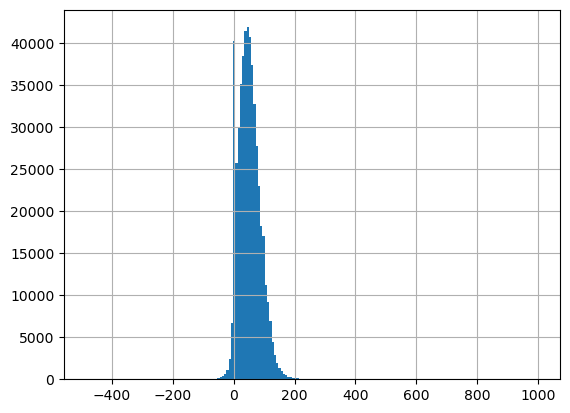

In [126]:
wdata['Lossper_GD'] = (wdata['LOSS']/wdata['LAST_UPB'])*100
wdata[(wdata['Lossper_GD']>-500) & (wdata['Lossper_GD']<1000)]['Lossper_GD'].hist(bins=200)

In [127]:
#wdata.to_csv('../CleanData.csv')

# OLS

In [128]:
from math import log
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import random

random.seed(10)
from pyearth import Earth

In [ ]:
# important before starting regression
wdata = wdata.dropna(axis = 0)
print(wdata.shape)

C:\Users\prith\AppData\Local\Temp\ipykernel_23824\4233065074.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  wdata.dropna(0, inplace=True)


(475757, 57)


In [130]:
wdata.columns

Index(['ACT_PERIOD', 'CHANNEL', 'ORIG_RATE', 'ORIG_UPB', 'CURRENT_UPB',
       'ORIG_TERM', 'OLTV', 'OCLTV', 'NUM_BO', 'DTI', 'CSCORE_B', 'FIRST_FLAG',
       'PROP', 'NO_UNITS', 'OCC_STAT', 'MSA', 'ZIP', 'PRODUCT', 'PPMT_FLG',
       'DLQ_STATUS', 'LAST_UPB', 'NON_INTEREST_BEARING_UPB',
       'HOMEREADY_PROGRAM_INDICATOR', 'RELOCATION_MORTGAGE_INDICATOR',
       'HIGH_LOAN_TO_VALUE_HLTV_REFINANCE_OPTION_INDICATOR', 'RE_PROCS_FLAG',
       'ORIG_DATE_m', 'ORIG_DATE_y', 'LAST_PAID_INSTALLMENT_DATE_m',
       'LAST_PAID_INSTALLMENT_DATE_y', 'FORECLOSURE_DATE_m',
       'FORECLOSURE_DATE_y', 'DISPOSITION_DATE_m', 'DISPOSITION_DATE_y',
       'FIRST_PAY_m', 'FIRST_PAY_y', 'ZB_DTE_m', 'ZB_DTE_y', 'ACCRUED_INT',
       'LOSS', 'FHA_Mean', 'UNEmpRate', 'Orig_HPI', 'Disp_HPI', 'MTM_LTV',
       'Loan_age', 'time_to_foreclose', 'PURPOSE_P', 'PURPOSE_R', 'PURPOSE_U',
       'method_fore_Judicial', 'method_fore_Power-of-Sale',
       'method_fore_Strict Foreclosure', 'Zero_Bal_Code_3.0',
       

LOSS/LGD Prediction

In [131]:
# Doing a random split now, 
#can be converted into time based split later

#outliers filtering 
sdata = wdata[(wdata['Lossper_GD']>-200) & (wdata['Lossper_GD']<400)]

train, evaluate = train_test_split(sdata, test_size=0.2)

In [132]:
#switch here between LOSS and Lossper_GD
output = 'Lossper_GD'

# loan age
# zero balance one hot -encoded

predictors= ['ORIG_RATE',  'ORIG_TERM', 'ORIG_UPB','LAST_UPB', 'OLTV', 'CSCORE_B','ORIG_DATE_m', 'ORIG_DATE_y',
           'UNEmpRate', 'time_to_foreclose', 'PURPOSE_P',
       'PURPOSE_R', 'method_fore_Judicial', 'OCLTV', 'Disp_HPI', 'FHA_Mean', 'Orig_HPI', 'UNEmpRate', 'MTM_LTV',
       'method_fore_Power-of-Sale', 'method_fore_Strict Foreclosure',
       'LAST_PAID_INSTALLMENT_DATE_m', 'LAST_PAID_INSTALLMENT_DATE_y',
       'FORECLOSURE_DATE_m', 'FORECLOSURE_DATE_y', 'DISPOSITION_DATE_m',
       'DISPOSITION_DATE_y', 'Zero_Bal_Code_3.0','Zero_Bal_Code_9.0', 'Zero_Bal_Code_15.0',]

Y_train = train[output]
#'HIGH_BAl_Y' - May not be present because it has unique value
X_train = train[predictors]

Y_eval = evaluate[output]
X_eval = evaluate[predictors]

In [133]:
# calculate aic for regression
def calculate_aic(n, mse, num_params):
 aic = n * log(mse) + 2 * num_params
 return aic
# calculate bic for regression
def calculate_bic(n, mse, num_params):
 bic = n * log(mse) + num_params * log(n)
 return bic

In [134]:
X_train_ = sm.add_constant(X_train)
model = sm.OLS(Y_train,X_train_.astype(float))
results = model.fit()

In [135]:
#publish these
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Lossper_GD   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     8196.
Date:                Fri, 01 Dec 2023   Prob (F-statistic):               0.00
Time:                        00:02:16   Log-Likelihood:            -1.8081e+06
No. Observations:              380480   AIC:                         3.616e+06
Df Residuals:                  380450   BIC:                         3.617e+06
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                          -2149.0721     86.529    -24.836      0.000   -2318.666   -1979.478
ORIG_RATE                         10.6071      0.104    102.146      0.000      10.404      10.811
ORIG_TERM                         -0.0463      0.001    -40.487      0.000      -0.049      -0.044
ORIG_UPB                          -0.0002   3.66e-06    -60.850      0.000      -0.000      -0.000
LAST_UPB                           0.0001   3.79e-06     26.404      0.000    9.26e-05       0.000
OLTV                              -0.2754      0.012    -22.089      0.000      -0.300      -0.251
CSCORE_B                           0.0074      0.001      8.645      0.000       0.006       0.009
ORIG_DATE_m                       -0.1846      0.014    -13.249      0.000      -0.212      -0.157
ORIG_DATE_y                       -1.0988      0.037    -29.665      0.000      -1.171      -1.026
UNEmpRate                          1.1513      0.018     64.489      0.000       1.116       1.186
time_to_foreclose                  0.0040      0.000     15.765      0.000       0.004       0.005
PURPOSE_P                        -10.3220      0.121    -85.153      0.000     -10.560     -10.084
PURPOSE_R                         -2.0091      0.120    -16.679      0.000      -2.245      -1.773
method_fore_Judicial               0.8978      0.748      1.200      0.230      -0.568       2.364
OCLTV                              0.1691      0.011     15.354      0.000       0.147       0.191
Disp_HPI                          -0.0903      0.001    -61.234      0.000      -0.093      -0.087
FHA_Mean                           4.2247      0.095     44.289      0.000       4.038       4.412
Orig_HPI                           0.0930      0.001     72.744      0.000       0.091       0.096
UNEmpRate                          1.1513      0.018     64.489      0.000       1.116       1.186
MTM_LTV                            0.1592      0.005     29.356      0.000       0.149       0.170
method_fore_Power-of-Sale         -2.7553      0.759     -3.631      0.000      -4.242      -1.268
method_fore_Strict Foreclosure    -0.0637      0.865     -0.074      0.941      -1.758       1.631
LAST_PAID_INSTALLMENT_DATE_m      -0.6674      0.014    -47.944      0.000      -0.695      -0.640
LAST_PAID_INSTALLMENT_DATE_y      -7.9497      0.043   -185.955      0.000      -8.033      -7.866
FORECLOSURE_DATE_m                -0.3566      0.017    -20.511      0.000      -0.391      -0.323
FORECLOSURE_DATE_y                -3.9199      0.123    -31.789      0.000      -4.162      -3.678
DISPOSITION_DATE_m                 1.1003      0.017     65.606      0.000       1.067       1.133
DISPOSITION_DATE_y                14.0043      0.113    124.469      0.000      13.784      14.225
Zero_Bal_Code_

In [136]:
# Sklearn learning and predictions on evaluation set
OLreg = LinearRegression()
OLreg.fit(X_train, Y_train)

LinearRegression()

In [137]:
Y_pred = OLreg.predict(X_eval)
print("R^2 :", r2_score(Y_eval, Y_pred))
mse = mean_squared_error(Y_eval, Y_pred)
print("AIC", calculate_aic(Y_eval.shape[0], mse, len(predictors)))

R^2 : 0.38577653965644143
AIC 632884.5315295832
